# Acknowledgements

The code for the transformer model is take from this tutorial https://www.tensorflow.org/text/tutorials/transformer

# Importing Libraries

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [41]:
ENCODER_LEN = 100
DECODER_LEN = 100
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*4

# Dataset

I have filtered and removed sentences that contain very few characters or several of them to inprove model performance.
Sentences in both english and hindi are then tokenized and padded to fix length

In [42]:
train_df = pd.read_csv("s.csv")
mask = (train_df['ENGLISH'].str.len()>20) & (train_df['ENGLISH'].str.len()<200)
train_df = train_df.loc[mask]

train_df.head()

,ENGLISH,bodo
0,Two of the best trains viz. Shatabdi express (between Delhi and Bhopal) and Taj Express (between Delhi and Gwalior) are available to access Agra.,रोखोमनै साबसिन त्रेइन जेरै- सताबदि अक्सप्रेस (देलही आरो भुपालनि गेजेराव) आरो ताज एक्सप्रेसनि (दिल्ली आरो गवालिरनि गेजेराव) आग्रासिम हाबग्रा लामाया थोजासे रोखोमनि।
1,"Agra, on cross roads of national highways 2, 3 and 11, is excellently connected to all parts of the country.","राजा लामानि 2, 3, आरो 11 आ आग्रासिम थांनो थाखाय हादोरनि गासैबो रोखोमनि लामाफोरजों जोबोद मोजाङै फोनांजाबनाय।"
2,Kheria Airport (Airport of Agra) is about 6 km from the Agra city centre and is easily accessible by taxis and auto rickshaws at nominal rates.,सेरिया बिरखं गाथोना (आग्रानि बिरखं गाथोन) आरो नोगोरनिफ्राय 6.कि.मि. गोजानाव आरो जायगायावनो मोलाय अटʼ रिक्सायाव होनांनाय बेसेनाबो थि जखानि।
3,"Agra is well connected by excellent train services to Delhi such as The Shatabdi Express (2 hrs), Taj Express (2. 5 hrs), Intercity Express (3 hrs).","आग्रानिफअराय दिल्लीसिम थांनो थाखाय त्रेइननि फोनांजाब राहाया जोबोद मोजां लोगोसे मखʼजाथाव त्रेइनफोरा जाबाय- साताबदि एक्स-प्रेस( 2 घन्टा) ताज अक्सप्रेस (2,5 घन्टा) इन्टारसिति अक्सप्रेस (3 घन्टा)।"
4,"Agra is the one of the prominent destinations of the World Tourism map with three heritage monuments, Taj Mahal, Red Fort & Fatehpur Sikri.",बुहुमनि दावबायारिफोरनि थाखाय आग्रानि मुंदांखा नायनो गोनां मान-सावगारिजों लोगोसे मोनथाम रोखोमनि गोसोखांथिया- ताज महल रेद फर्ट आरो फातेहपुर सिकरि।


In [43]:
pd.set_option('display.max_colwidth', None)

In [44]:
eng = train_df['ENGLISH']
hind = train_df['bodo']
eng = eng.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
hind = hind.apply(lambda x: "<SOS> "+ str(x) + " <EOS>")

In [45]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
hind_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
eng_tokenizer.fit_on_texts(eng)
hind_tokenizer.fit_on_texts(hind)
inputs = eng_tokenizer.texts_to_sequences(eng)
targets = hind_tokenizer.texts_to_sequences(hind)

In [46]:
print(eng_tokenizer)
print(hind_tokenizer)

In [47]:

train_df.drop_duplicates()

,ENGLISH,bodo
0,Two of the best trains viz. Shatabdi express (between Delhi and Bhopal) and Taj Express (between Delhi and Gwalior) are available to access Agra.,रोखोमनै साबसिन त्रेइन जेरै- सताबदि अक्सप्रेस (देलही आरो भुपालनि गेजेराव) आरो ताज एक्सप्रेसनि (दिल्ली आरो गवालिरनि गेजेराव) आग्रासिम हाबग्रा लामाया थोजासे रोखोमनि।
1,"Agra, on cross roads of national highways 2, 3 and 11, is excellently connected to all parts of the country.","राजा लामानि 2, 3, आरो 11 आ आग्रासिम थांनो थाखाय हादोरनि गासैबो रोखोमनि लामाफोरजों जोबोद मोजाङै फोनांजाबनाय।"
2,Kheria Airport (Airport of Agra) is about 6 km from the Agra city centre and is easily accessible by taxis and auto rickshaws at nominal rates.,सेरिया बिरखं गाथोना (आग्रानि बिरखं गाथोन) आरो नोगोरनिफ्राय 6.कि.मि. गोजानाव आरो जायगायावनो मोलाय अटʼ रिक्सायाव होनांनाय बेसेनाबो थि जखानि।
3,"Agra is well connected by excellent train services to Delhi such as The Shatabdi Express (2 hrs), Taj Express (2. 5 hrs), Intercity Express (3 hrs).","आग्रानिफअराय दिल्लीसिम थांनो थाखाय त्रेइननि फोनांजाब राहाया जोबोद मोजां लोगोसे मखʼजाथाव त्रेइनफोरा जाबाय- साताबदि एक्स-प्रेस( 2 घन्टा) ताज अक्सप्रेस (2,5 घन्टा) इन्टारसिति अक्सप्रेस (3 घन्टा)।"
4,"Agra is the one of the prominent destinations of the World Tourism map with three heritage monuments, Taj Mahal, Red Fort & Fatehpur Sikri.",बुहुमनि दावबायारिफोरनि थाखाय आग्रानि मुंदांखा नायनो गोनां मान-सावगारिजों लोगोसे मोनथाम रोखोमनि गोसोखांथिया- ताज महल रेद फर्ट आरो फातेहपुर सिकरि।
...,...,...
95,The paintings in the Ajanta caves are often mistakenly referred to as frescoes.,अजन्ता खरफोरनि सावगारि आखिनायफोरा थाबैनो गोरोन्थियै फ्रेसकʼस होननानै फोरमायथि जायो।
96,A fresco refers to the application of colors to moist lime plaster.,मोनसे फ्रेस्कʼआ फोरमायथियौ गुरै सिमेन्ट प्लास्टाराव गाबफोरनि बाहायनाय।
97,"At Ajanta, the paintings were done on dry wall.","अजन्तायाव, गोरान इन्जुरफोराव सावगारि एरनाय जादोंमोन।"
98,"According to an ingenious theory, the depression in the floor of the main chambers, a feature of all caves, was filled with water, which caught the few rays that did reach into the darkness.","नायबिजिरगिरि सानथौ बादिब्ला गाहाय थाग्रा नʼनि बारान्दानिफ्राय नायरहरजानाय गासै खरंआ मोनसे आखउथाय, दैजों साग्लोबनाय, जायनोखि खायसे रोदाफोरा खोमसि जायगासिम सौहैदोंमोन।"


In [48]:
# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df['ENGLISH'] = train_df['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'बड़ो' column
train_df['bodo'] = train_df['bodo'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df['ENGLISH'] = train_df['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'बड़ो' column
train_df['bodo'] = train_df['bodo'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df['ENGLISH'] = train_df['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'बड़ो' column
train_df['bodo'] = train_df['bodo'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df.replace('', np.nan, inplace=True)
train_df.dropna(subset=['ENGLISH', 'bodo'], inplace=True)

# Save the cleaned data to a new CSV file
train_df.to_csv('sd.csv', index=False)

train_df=pd.read_csv('sd.csv')


In [49]:
train_df

,ENGLISH,bodo
0,two of the best trains viz shatabdi express between delhi and bhopal and taj express between delhi and gwalior are available to access agra,रोखोमनै साबसिन त्रेइन जेरै सताबदि अक्सप्रेस देलही आरो भुपालनि गेजेराव आरो ताज एक्सप्रेसनि दिल्ली आरो गवालिरनि गेजेराव आग्रासिम हाबग्रा लामाया थोजासे रोखोमनि।
1,agra on cross roads of national highways and is excellently connected to all parts of the country,राजा लामानि आरो आ आग्रासिम थांनो थाखाय हादोरनि गासैबो रोखोमनि लामाफोरजों जोबोद मोजाङै फोनांजाबनाय।
2,kheria airport airport of agra is about km from the agra city centre and is easily accessible by taxis and auto rickshaws at nominal rates,सेरिया बिरखं गाथोना आग्रानि बिरखं गाथोन आरो नोगोरनिफ्राय किमि गोजानाव आरो जायगायावनो मोलाय अट रिक्सायाव होनांनाय बेसेनाबो थि जखानि।
3,agra is well connected by excellent train services to delhi such as the shatabdi express hrs taj express hrs intercity express hrs,आग्रानिफअराय दिल्लीसिम थांनो थाखाय त्रेइननि फोनांजाब राहाया जोबोद मोजां लोगोसे मखजाथाव त्रेइनफोरा जाबाय साताबदि एक्सप्रेस घन्टा ताज अक्सप्रेस घन्टा इन्टारसिति अक्सप्रेस घन्टा।
4,agra is the one of the prominent destinations of the world tourism map with three heritage monuments taj mahal red fort fatehpur sikri,बुहुमनि दावबायारिफोरनि थाखाय आग्रानि मुंदांखा नायनो गोनां मानसावगारिजों लोगोसे मोनथाम रोखोमनि गोसोखांथिया ताज महल रेद फर्ट आरो फातेहपुर सिकरि।
...,...,...
87,the paintings in the ajanta caves are often mistakenly referred to as frescoes,अजन्ता खरफोरनि सावगारि आखिनायफोरा थाबैनो गोरोन्थियै फ्रेसकस होननानै फोरमायथि जायो।
88,a fresco refers to the application of colors to moist lime plaster,मोनसे फ्रेस्कआ फोरमायथियौ गुरै सिमेन्ट प्लास्टाराव गाबफोरनि बाहायनाय।
89,at ajanta the paintings were done on dry wall,अजन्तायाव गोरान इन्जुरफोराव सावगारि एरनाय जादोंमोन।
90,according to an ingenious theory the depression in the floor of the main chambers a feature of all caves was filled with water which caught the few rays that did reach into the darkness,नायबिजिरगिरि सानथौ बादिब्ला गाहाय थाग्रा ननि बारान्दानिफ्राय नायरहरजानाय गासै खरंआ मोनसे आखउथाय दैजों साग्लोबनाय जायनोखि खायसे रोदाफोरा खोमसि जायगासिम सौहैदोंमोन।


In [50]:
ENCODER_VOCAB = len(eng_tokenizer.word_index) + 1
DECODER_VOCAB = len(hind_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

722 905


In [51]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [52]:
print(inputs)
print(targets)

tf.Tensor(
[[  4 112   3 ...   0   0   0]
 [  4  12  19 ...   0   0   0]
 [  4 234 118 ...   0   0   0]
 ...
 [  4  37  75 ...   0   0   0]
 [  4 701  10 ...   0   0   0]
 [  4 715 716 ...   0   0   0]], shape=(93, 100), dtype=int64)
tf.Tensor(
[[  2 229  51 ...   0   0   0]
 [  2  55  98 ...   0   0   0]
 [  2 245 101 ...   0   0   0]
 ...
 [  2 881 882 ...   0   0   0]
 [  2 884 203 ...   0   0   0]
 [  2 898  14 ...   0   0   0]], shape=(93, 100), dtype=int64)


In [53]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Transformer Model

The next several blocks of code contain the vanilla Transformer model.

If you want to know about what they are and how they work I suggest this video: https://www.youtube.com/watch?v=4Bdc55j80l8

It does an excellent job of giving an overview about them and helped me in understanding them.

In [54]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [55]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [56]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [57]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [58]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
    

In [59]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [60]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 100

# Custom Learning Rate

In [61]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [62]:
optimizer = Adam(learning_rate=0.001)


Text(0.5, 0, 'Train Step')

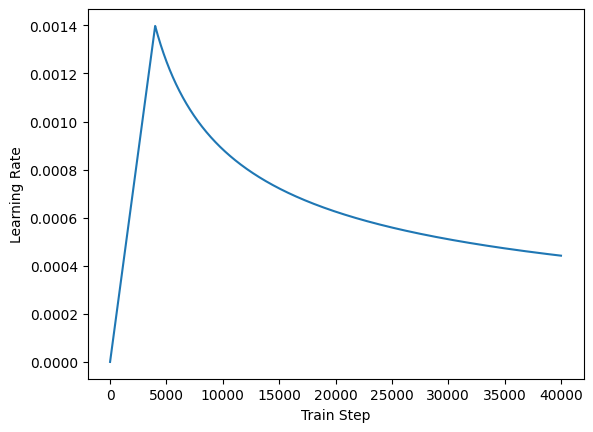

In [63]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Custom Loss and Accuracy

In [64]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [65]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [66]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [67]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [68]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [69]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

# Training the Model

In [70]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 200 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0436 Accuracy 0.9980
Epoch 1 Loss 0.0430 Accuracy 0.9980
Time taken for 1 epoch: 87.43268585205078 secs

Epoch 2 Batch 0 Loss 0.0423 Accuracy 0.9983
Epoch 2 Loss 0.0416 Accuracy 0.9982
Time taken for 1 epoch: 8.19494366645813 secs

Epoch 3 Batch 0 Loss 0.0398 Accuracy 0.9986
Epoch 3 Loss 0.0418 Accuracy 0.9981
Time taken for 1 epoch: 12.157160758972168 secs

Epoch 4 Batch 0 Loss 0.0392 Accuracy 0.9982
Epoch 4 Loss 0.0401 Accuracy 0.9982
Time taken for 1 epoch: 6.928151607513428 secs

Epoch 5 Batch 0 Loss 0.0395 Accuracy 0.9982
Saving checkpoint for epoch 5 at checkpoints\ckpt-37
Epoch 5 Loss 0.0408 Accuracy 0.9983
Time taken for 1 epoch: 7.64465856552124 secs

Epoch 6 Batch 0 Loss 0.0412 Accuracy 0.9982
Epoch 6 Loss 0.0398 Accuracy 0.9982
Time taken for 1 epoch: 11.514622449874878 secs

Epoch 7 Batch 0 Loss 0.0395 Accuracy 0.9982
Epoch 7 Loss 0.0392 Accuracy 0.9983
Time taken for 1 epoch: 7.080878496170044 secs

Epoch 8 Batch 0 Loss 0.0355 Accuracy 0.9984
Epoch 8

In [82]:
def evaluate(text):
    text = eng_tokenizer.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(text[0], 0)

    decoder_input = [hind_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == hind_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [83]:
def translate(eng_text):
    hind_text = evaluate(text=eng_text)[0].numpy()
    hind_text = np.expand_dims(hind_text[1:], 0)  
    return hind_tokenizer.sequences_to_texts(hind_text)[0]

# Predictions

Below are 2 translation predictions, the first one is on a sentence that was in the dataset and the other one that I wrote 
by myself.

In [84]:
translate("That politics , in retrospect , was rooted in a false ideology")

'मोनसे बेंखनारि गहेना आरो बर्ग खुन्थिया बाहायनाया गोरोबथाय दाथाइ सोरजिदों।'

In [85]:
translate("Above the tombs is a Cairene lamp, the flame of which is supposed to never burn out.")


'खाम्फानि सायाव केरिन लेमथन दं जायनि जोंनाय अर सालाया जोबनो रोङै बायदि जोंबाय थायो।'

In [86]:
import csv
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def read_csv_file(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            sentences.append(row)
    return sentences

def compute_bleu_score(reference_sentences, predicted_sentences):
    references = [[ref] for ref in reference_sentences]
    hypotheses = [hyp for hyp in predicted_sentences]
    
    smooth_func = SmoothingFunction().method4  # Apply smoothing to BLEU score
    
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smooth_func)
    return bleu_score

# Load training and testing data from CSV files
train_file = r'C:\Users\dassn\OneDrive\Desktop\Project\ad\sd.csv'
test_file = r'C:\Users\dassn\OneDrive\Desktop\Project\ad\testset2.csv'

train_data = read_csv_file(train_file)
test_data = read_csv_file(test_file)

# Assuming the source and target translations are stored in columns 0 and 1, respectively
train_source_sentences = [row[0] for row in train_data]
train_target_sentences = [row[1] for row in train_data]

test_source_sentences = [row[0] for row in test_data]
test_target_sentences = [row[1] for row in test_data]

# Compute BLEU score on the test set using the training set as references
bleu = compute_bleu_score(train_target_sentences, test_target_sentences)

print(f"BLEU score: {bleu}")

BLEU score: 0.17741851289512292


In [96]:
import csv
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split

def read_csv_file(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            sentences.append(row)
    return sentences

def compute_bleu_score(reference_sentences, predicted_sentences):
    references = [[ref] for ref in reference_sentences]
    hypotheses = [hyp for hyp in predicted_sentences]
    
    smooth_func = SmoothingFunction().method4  # Apply smoothing to BLEU score
    
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smooth_func)
    return bleu_score

# Load data from CSV file
file_path = r'C:\Users\dassn\OneDrive\Desktop\Project\ad\sd.csv'
data = read_csv_file(file_path)

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Assuming the source and target translations are stored in columns 0 and 1, respectively
train_source_sentences = [row[0] for row in train_data]
train_target_sentences = [row[1] for row in train_data]

test_source_sentences = [row[0] for row in test_data]
test_target_sentences = [row[1] for row in test_data]

# Generate predicted sentences using your model
# Replace the following lines with your code to generate predicted sentences

# Ensure the number of target sentences matches in training and testing sets
train_len = len(train_target_sentences)
test_len = len(test_target_sentences)
if train_len > test_len:
    train_target_sentences = train_target_sentences[:test_len]
elif train_len < test_len:
    test_target_sentences = test_target_sentences[:train_len]

# Compute BLEU score on the test set using the training set as references
bleu = compute_bleu_score(train_target_sentences, test_target_sentences)

print(f"BLEU score: {bleu}")


BLEU score: 0.18090222301362932


In [98]:
import csv
import sacrebleu
from sklearn.model_selection import train_test_split

def read_csv_file(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            sentences.append(row)
    return sentences

# Load data from CSV file
file_path = r'C:\Users\dassn\OneDrive\Desktop\Project\ad\sd.csv'
data = read_csv_file(file_path)

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Assuming the source and target translations are stored in columns 0 and 1, respectively
train_source_sentences = [row[0] for row in train_data]
train_target_sentences = [row[1] for row in train_data]

test_source_sentences = [row[0] for row in test_data]
test_target_sentences = [row[1] for row in test_data]

# Generate predicted sentences using your model
# Replace the following lines with your code to generate predicted sentences

# Ensure the number of target sentences matches in training and testing sets
train_len = len(train_target_sentences)
test_len = len(test_target_sentences)
if train_len > test_len:
    train_target_sentences = train_target_sentences[:test_len]
elif train_len < test_len:
    test_target_sentences = test_target_sentences[:train_len]

# Compute BLEU score using sacrebleu
bleu = sacrebleu.corpus_bleu(test_target_sentences, [train_target_sentences])

print(f"Sacre BLEU score: {bleu.score}")


Sacre BLEU score: 0.21090587084851684


In [105]:
import csv
from nltk.translate import meteor_score
from sklearn.model_selection import train_test_split

def read_csv_file(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            sentences.append(row)
    return sentences

# Load data from CSV file
file_path = r'C:\Users\dassn\OneDrive\Desktop\Project\ad\sd.csv'
data = read_csv_file(file_path)

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Assuming the source and target translations are stored in columns 0 and 1, respectively
train_source_sentences = [row[0] for row in train_data]
train_target_sentences = [row[1] for row in train_data]

test_source_sentences = [row[0] for row in test_data]
test_target_sentences = [row[1] for row in test_data]

# Generate predicted sentences using your model
# Replace the following lines with your code to generate predicted sentences

# Ensure the number of target sentences matches in training and testing sets
train_len = len(train_target_sentences)
test_len = len(test_target_sentences)
if train_len > test_len:
    train_target_sentences = train_target_sentences[:test_len]
elif train_len < test_len:
    test_target_sentences = test_target_sentences[:train_len]

# Convert tokenized sentences back to strings
test_target_sentences = [' '.join(tokens) for tokens in test_target_sentences]
train_target_sentences = [' '.join(tokens) for tokens in train_target_sentences]

# Compute METEOR score
meteor = meteor_score.meteor_score(test_target_sentences, train_target_sentences)

print(f"METEOR score: {meteor}")


TypeError: "reference" expects pre-tokenized reference (Iterable[str]): म ज ि त न ि   स ि ग ा ङ ा व   थ ा न ा य   ब ै स ा ङ ा   ग ो र ज ा   ब ा ल ा   अ न थ ा इ न ि ।